In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pickle
import pathlib as pl
from typing import Dict, Any

import candas as can
import gumbi as gmb
import logging


In [2]:
# Setup logging
logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger(__name__)

# Setup paths
# code_pth = pl.Path(__file__).parent
code_pth = pl.Path.cwd()
fig_pth = code_pth.parent
gen_pth = fig_pth / "generated"
graph_pth = fig_pth / "graphics"
graph_pth.mkdir(exist_ok=True)


In [3]:
from utils import savefig

In [4]:

# Plotting parameters
width = 7.08
height = 1.45
figsize = (width, height)
ticklabelsize = 6
labelsize = 8
titlesize = labelsize
spotsize = 15

# Set rcParams for plotting
# mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse
plt.style.use(str(can.style.breve))
mpl.rc("xtick", labelsize=ticklabelsize)
mpl.rc("ytick", labelsize=ticklabelsize)
mpl.rc("axes", labelsize=labelsize, titlesize=titlesize, linewidth=0.5)

mar_l = 0.11
mar_r = 0.15
mar_t = 0.5
mar_b = 2.7


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    logger.info("Formatting figure with figsize=%s", figsize)
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs,
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.0, width=0.5)


Saving fig_ED1Fii__weak_yaksha in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


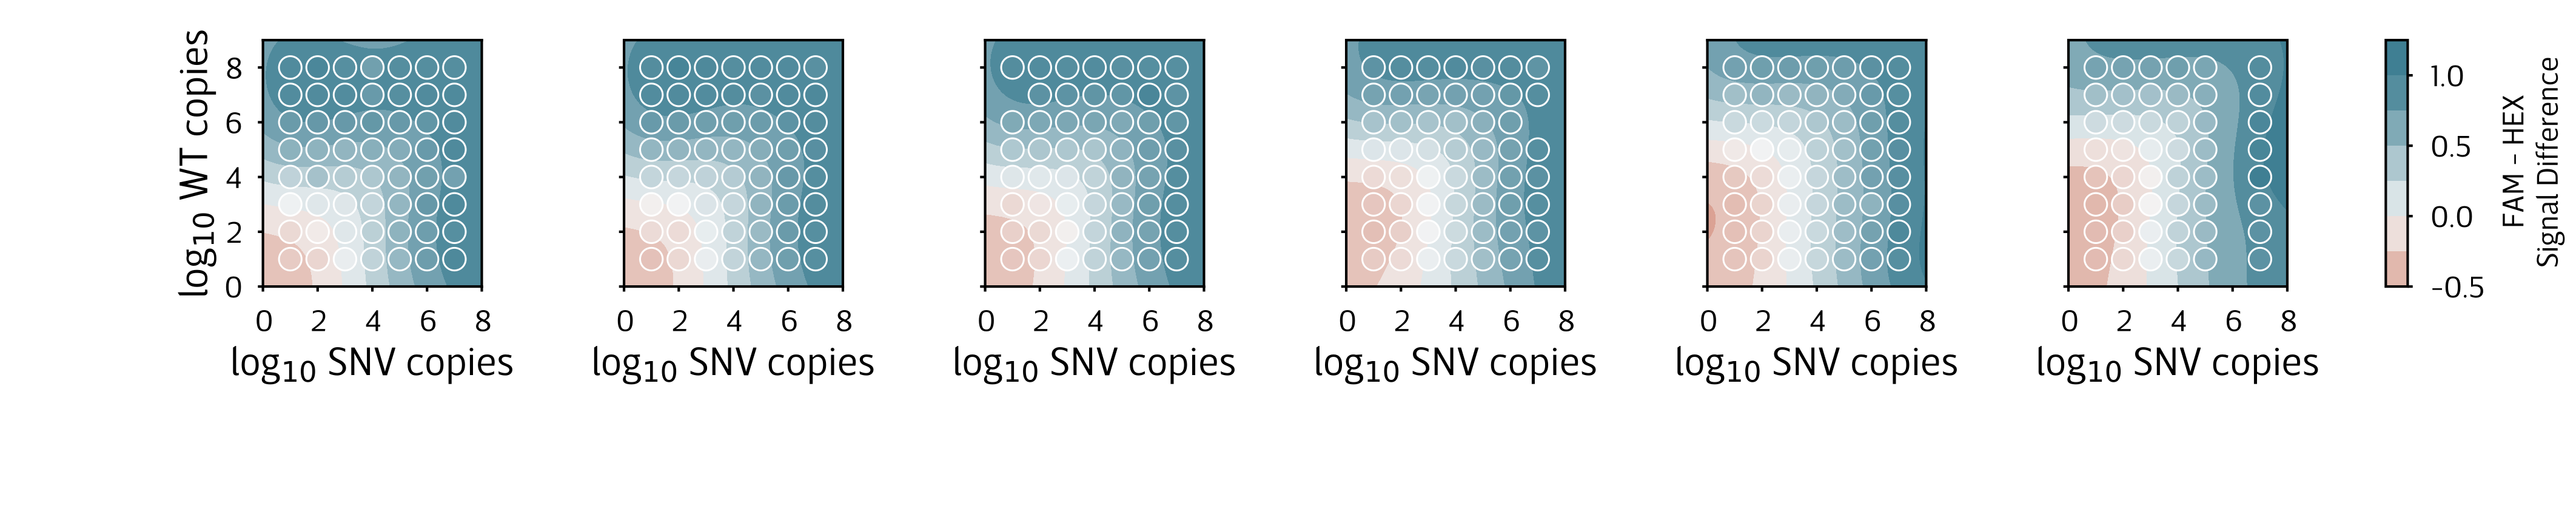

In [18]:


def load_models():
    """Load the fitted GP models"""
    logger.info("Loading fitted GP models...")
    with open(gen_pth / "gp_model.pkl", "rb") as f:
        gp = pickle.load(f)
    with open(gen_pth / "gp_zero_model.pkl", "rb") as f:
        gp_zero = pickle.load(f)
    with open(gen_pth / "uncertainty_params.pkl", "rb") as f:
        uncertainty_params = pickle.load(f)
    logger.info("Loaded GP models and uncertainty parameters.")
    return gp, gp_zero, uncertainty_params


def load_stdzr():
    """Load standardization parameters"""
    logger.info("Loading standardization parameters...")
    with open(gen_pth / "stdzr.pkl", "rb") as f:
        stdzr = pickle.load(f)
    logger.info("Loaded standardization parameters.")
    return stdzr


def load_predictions(panel: int, axis: int, wt_copies: int = None) -> Dict[str, Any]:
    """Load predictions for a specific panel and axis"""
    logger.info(f"Loading predictions for panel={panel}, axis={axis}, wt_copies={wt_copies}")
    stdzr = load_stdzr()
    if panel == 0:
        with open(gen_pth / f"weak_yaksha_predictions_axis_{axis}.pkl", "rb") as f:
            predictions = pickle.load(f)
    elif panel == 1:
        with open(
            gen_pth / f"big_zebra_predictions_axis_{axis}_wt_{wt_copies:.1f}.pkl", "rb"
        ) as f:
            predictions = pickle.load(f)
    else:  # panel 2
        with open(gen_pth / f"vibrant_ibis_predictions_axis_{axis}.pkl", "rb") as f:
            predictions = pickle.load(f)

    for k, v in predictions.items():
        if k.endswith("names"):
            predictions[k.removesuffix("_names")].names = v
        if k.endswith("name"):
            predictions[k.removesuffix("_name")].name = v
        if isinstance(v, (gmb.ParameterArray, gmb.UncertainParameterArray)):
            predictions[k].stdzr = stdzr

    logger.info(f"Loaded predictions keys: {list(predictions.keys())}")
    return predictions


def plot_heatmap(ax, predictions, endpoints, col_val):
    """Plot heatmap for a single axis"""
    logger.info("Plotting heatmap for col_val=%s", col_val)
    norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
    cmap = sns.diverging_palette(20, 220, as_cmap=True)

    ax.set_aspect("equal")
    ax.set(yticks=[0, 2, 4, 6, 8], xticks=[0, 2, 4, 6, 8], ylim=[0, 9], xlim=[0, 8])

    plt.sca(ax)
    pc = gmb.ParrayPlotter(
        x=predictions["SNV"], y=predictions["WT"], z=predictions["signal"]
    )(plt.contourf, cmap=cmap, norm=norm, zorder=-10)

    ax.set_xlabel(r"log$_{10}$ SNV copies", labelpad=ticklabelsize / 4)
    ax.set_ylabel(r"log$_{10}$ WT copies", labelpad=ticklabelsize / 4)

    return pc


"""Plot heatmap panel"""
logger.info("Plotting panel 0 (heatmap)...")
# Load endpoints
endpoints = pd.read_pickle(gen_pth / "endpoints.pkl")
nonblank_endpoints = pd.read_pickle(gen_pth / "nonblank_endpoints.pkl")

# Create figure
g = sns.relplot(
    data=nonblank_endpoints,
    col="Blocker μM",
    x="SNV_lg10_Copies",
    y="WT_lg10_Copies",
    hue="SignalDifference",
    hue_norm=mpl.colors.Normalize(vmin=-1, vmax=+1),
    palette=sns.diverging_palette(20, 220, as_cmap=True),
    legend=False,
    kind="scatter",
    height=2,
    aspect=1.0,
    s=20,
    zorder=10,
    facet_kws={"margin_titles": True, "despine": False},
)
g.set_titles(
    col_template="",#,  "{col_name:.2f} μM",
    row_template="{row_name}",
    fontsize=titlesize,
    pad=titlesize / 2,
)
g.set(xticks=[0, 2, 4, 6, 8])

# Plot predictions for each axis
for i, (col_val, ax) in enumerate(g.axes_dict.items()):
    logger.info(f"Panel 0: Plotting axis {i}, col_val={col_val}")
    predictions = load_predictions(0, i)
    logger.info(f"Panel 0: predictions keys: {predictions.keys()}")
    pc = plot_heatmap(ax, predictions, endpoints, col_val)

    # Add colorbar to last axis
    if i == len(g.axes_dict) - 1:
        cax = ax.inset_axes([1.45, 0.0, 0.1, 1], transform=ax.transAxes)
        plt.colorbar(
            pc,
            cax=cax,
            label="Signal\nDifference",
            ticks=[-1, -0.5, 0, 0.5, 1],
            format="%.1f",
        )
        cax.yaxis.set_tick_params(labelsize=ticklabelsize, length=1.0, width=0.5)
        cax.set_ylabel(
            "FAM - HEX\nSignal Difference",
            ha="center",
            va="top",
            fontsize=ticklabelsize,
        )

format_fig(
    plt.gcf(),
    figsize=(width, height),
    mar_l=0.148,
    mar_r=0.1625,
    mar_t=mar_t,
    mar_b=mar_b+mar_t,
    wspace=0.65,
)

savefig(plt.gcf(), alias="weak_yaksha")
logger.info("Panel 0 plots saved.")

Saving fig_ED1Fi__big_zebra in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


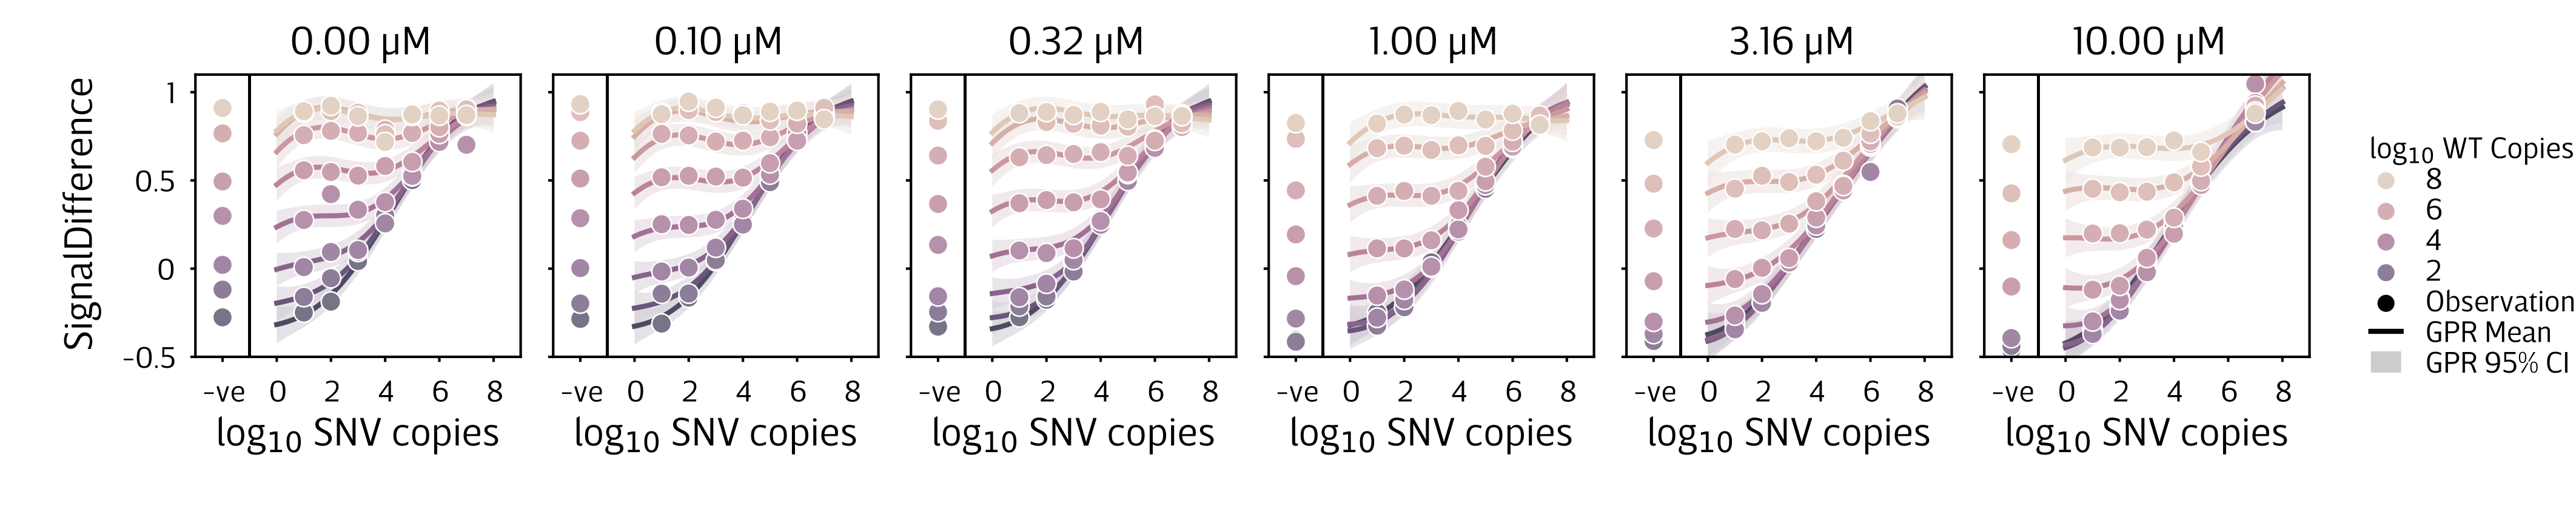

In [17]:

def plot_signal_vs_snv(ax, predictions, endpoints, col_val, wt_copies):
    """Plot signal vs SNV for a single axis and WT copy level"""
    logger.info("Plotting signal vs SNV for col_val=%s, wt_copies=%s", col_val, wt_copies)
    pal = sns.color_palette("ch:s=-.2,r=.6", n_colors=9)
    rgb = pal[9 - wt_copies]  # Reverse index to match original color scheme


    plt.sca(ax)
    gmb.ParrayPlotter(x=predictions["SNV"], y=predictions["signal"]).plot(
        palette=sns.light_palette(rgb), line_kws=dict(lw=1)
    )

    sns.scatterplot(
        data=endpoints[
            (endpoints["Blocker μM"] == col_val)
            & (endpoints["WT_lg10_Copies"] == wt_copies)
        ],
        x="SNV_lg10_Copies",
        y="SignalDifference",
        s=spotsize,
        color=sns.light_palette(rgb)[-3],
        ax=ax,
    )

    ax.axvline(-1, color="k", lw=0.5)
    ax.set_title("")

"""Plot signal vs SNV panel"""
logger.info("Plotting panel 1 (signal vs SNV)...")
# Load endpoints
endpoints = pd.read_pickle(gen_pth / "endpoints.pkl")

# Create figure
g = sns.FacetGrid(
    data=endpoints,
    col="Blocker μM",
    height=2,
    aspect=1,
    **{"margin_titles": True, "despine": False},
)

# Plot predictions for each axis and WT copy level
for i, (col_val, ax) in enumerate(g.axes_dict.items()):
    logger.info(f"Panel 1: Plotting axis {i}, col_val={col_val}")
    for wt_copies in range(1, 9):
        logger.info(f"Panel 1: Plotting wt_copies={wt_copies}")
        predictions = load_predictions(1, i, wt_copies)
        plot_signal_vs_snv(ax, predictions, endpoints, col_val, wt_copies)

# Add legend to last axis
rax = g.axes[0, -1]
xl = rax.get_xlim()
yl = rax.get_ylim()

pal = sns.color_palette("ch:s=-.2,r=.6", n_colors=9)
dummies = []
labels = []

for i, (copies, rgb) in enumerate(zip(range(1, 9)[::-1], pal[1:])):
    if i % 2:
        continue
    dummies.append(
        rax.scatter(
            x=[-10],
            y=[-10],
            marker="o",
            color=sns.light_palette(rgb)[-3],
            s=spotsize,
            edgecolor="w",
            linewidths=0.5,
        )
    )
    labels.append(str(copies))

dummies.append(
    rax.scatter(
        x=[-10],
        y=[-10],
        marker="o",
        color="k",
        s=spotsize,
        edgecolor="w",
        linewidths=0.5,
    )
)
labels.append("Observation")

dummies.append(rax.plot([-10, -10], [-10, -10], color="k", linewidth=1)[0])
labels.append("GPR Mean")

dummies.append(
    rax.fill_between(
        [-10, -10], [-10, -10], [-10, -10], color="k", alpha=0.2, edgecolor="none"
    )
)
labels.append("GPR 95% CI")

rax.set_xlim(xl)
rax.set_ylim(yl)

rax.legend(
    dummies,
    labels,
    title=r"log$_{10}$ WT Copies",
    loc="center left",
    bbox_to_anchor=(1.1, 0.35),
    frameon=False,
    fontsize=ticklabelsize,
    title_fontsize=ticklabelsize,
    handlelength=1.0,
    labelspacing=0.05,
)

g.set_xticklabels(fontsize=ticklabelsize)
g.set_yticklabels(fontsize=ticklabelsize)
g.set_xlabels(
    r"log$_{10}$ SNV copies", fontsize=labelsize, labelpad=ticklabelsize / 4
)

g.set(
    yticks=[-0.5, 0, 0.5, 1],
    yticklabels=[-0.5, 0, 0.5, 1],
    xticks=[-2, 0, 2, 4, 6, 8],
    xticklabels=["-ve", 0, 2, 4, 6, 8],
    ylim=[-0.5, 1.1],
    xlim=[-3, 9],
)

g.set_titles(
    col_template="{col_name:.2f} μM",
    row_template="{row_name}",
    fontsize=titlesize,
    pad=titlesize / 2,
)

format_fig(plt.gcf(),
    mar_t=mar_t * 2, mar_b=mar_b*0.85, wspace=0.1)

savefig(plt.gcf(), alias="big_zebra")
logger.info("Panel 1 plots saved.")


In [7]:
gp, gp_zero, uncertainty_params = load_models()
ds = gp.data
ds_zero = gp_zero.data

In [8]:
σ_aleatoric = uncertainty_params['σ_aleatoric']
min_detectable_diff = uncertainty_params['min_detectable_diff']

diff_from_zero = (
    ds.wide.set_index(
        ["Blocker μM", "WT_lg10_Copies", "SNV_lg10_Copies"]
    ).SignalDifference
    - ds_zero.wide.set_index(["Blocker μM", "WT_lg10_Copies"]).SignalDifference
) > min_detectable_diff

obsd_lods = (
    diff_from_zero[diff_from_zero]
    .reset_index()
    .groupby(["Blocker μM", "WT_lg10_Copies"])
    .SNV_lg10_Copies.apply(np.min)
)
obsd_vafs = (
    obsd_lods - obsd_lods.reset_index().WT_lg10_Copies.values
).rename("log10 VAF").reset_index()

Saving fig_ED1Fiii__vibrant_ibis in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


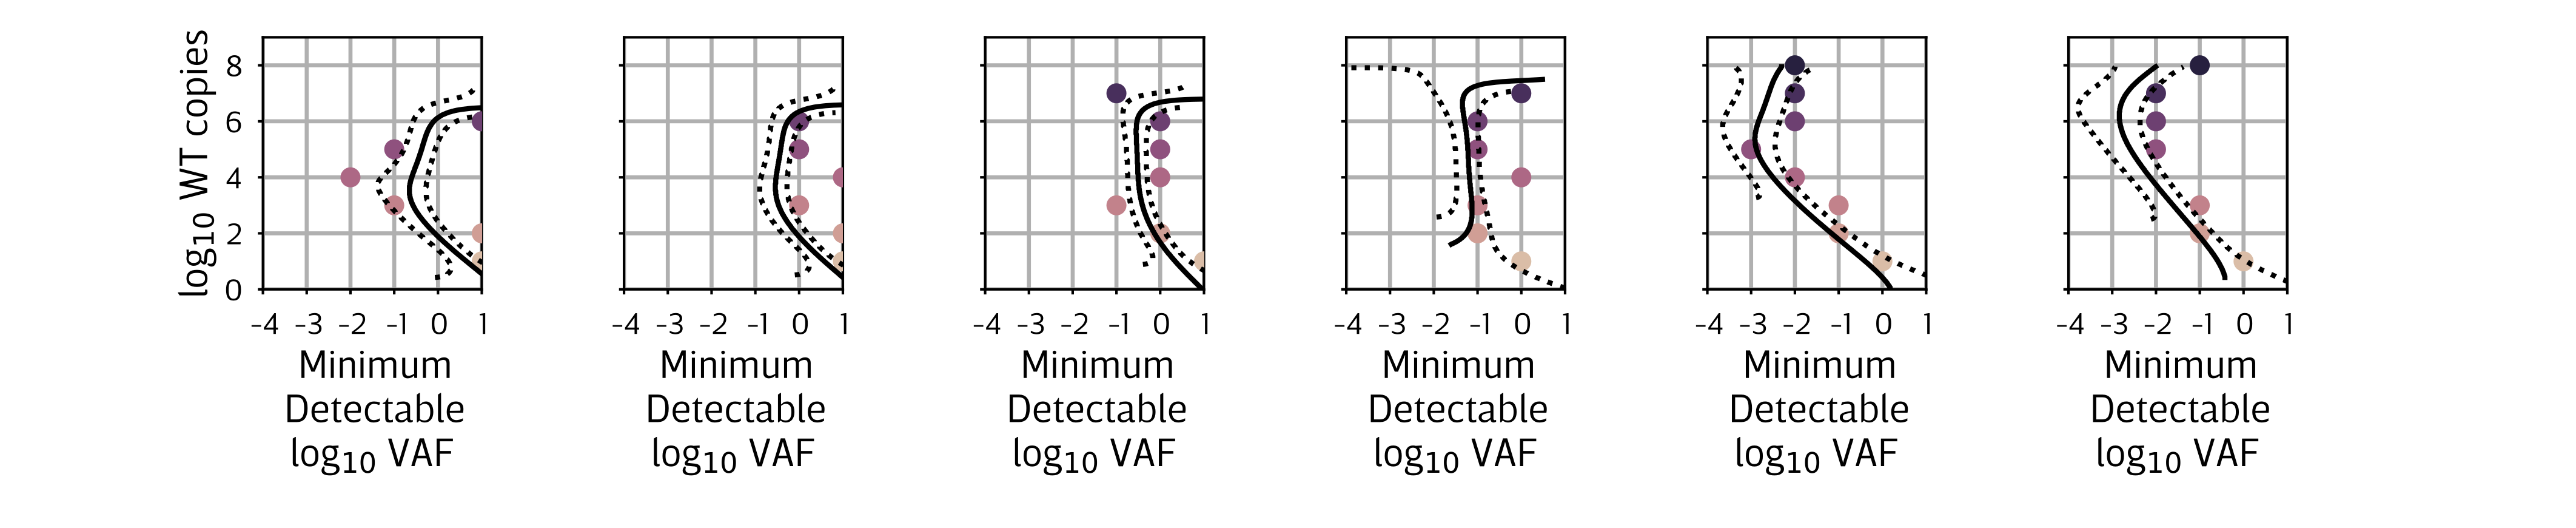

In [13]:

def plot_vaf(ax, predictions, obsd_vafs, col_val):
    """Plot VAF analysis for a single axis"""
    logger.info("Plotting VAF for col_val=%s", col_val)
    pal = sns.color_palette("ch:s=-.2, r=.6", n_colors=9)[1:]

    ax.plot(
        predictions["vaf_m"][5:-5], predictions["wt_vec"][5:-5], color="k", lw=1, ls="-", zorder=100
    )
    ax.plot(
        predictions["vaf_l"][5:-5], predictions["wt_vec"][5:-5], color="k", lw=1, ls=":", zorder=100
    )
    ax.plot(
        predictions["vaf_u"][5:-5], predictions["wt_vec"][5:-5], color="k", lw=1, ls=":", zorder=100
    )

    these_obsd_vafs = obsd_vafs[obsd_vafs["Blocker μM"] == col_val]

    ax.scatter(
        these_obsd_vafs["log10 VAF"],
        these_obsd_vafs["WT_lg10_Copies"],
        color=[
            c
            for i, c in enumerate(pal)
            if i + 1 in these_obsd_vafs["WT_lg10_Copies"].values
        ],
        s=np.sqrt(spotsize),
        zorder=10,
    )

    ax.set(
        yticks=[0, 2, 4, 6, 8], xticks=[-4, -3, -2, -1, 0, 1], ylim=[0, 9], xlim=[-4, 1]
    )
    ax.grid(which="both", zorder=-100)

    
"""Plot VAF panel"""
logger.info("Plotting panel 2 (VAF)...")
# Load endpoints
endpoints = pd.read_pickle(gen_pth / "endpoints.pkl")

# Create figure
g = sns.FacetGrid(
    data=endpoints,
    col="Blocker μM",
    height=4,
    aspect=0.9,
    **{"margin_titles": True, "despine": False},
)

g.set_titles(col_template="")

# Plot predictions for each axis
for i, (col_val, ax) in enumerate(g.axes_dict.items()):
    logger.info(f"Panel 2: Plotting axis {i}, col_val={col_val}")
    predictions = load_predictions(2, i)
    plot_vaf(ax, predictions, obsd_vafs, col_val)

format_fig(
    plt.gcf(),
    figsize=(width, height),
    mar_l=0.148,
    mar_r=0.1625,
    mar_t=mar_t,
    mar_b=mar_b+mar_t,
    wspace=0.65,
)

g.set_xlabels(
    "Minimum\nDetectable\n"+r"log$_{10}$ VAF",
    fontsize=labelsize,
    labelpad=ticklabelsize / 4,
)

g.axes[0, 0].set_ylabel(r"log$_{10}$ WT copies", labelpad=ticklabelsize / 4)
g.axes[0, 0].set_yticklabels([0, 2, 4, 6, 8], fontsize=ticklabelsize)

savefig(plt.gcf(), alias="vibrant_ibis")
logger.info("Panel 2 plots saved.")
